# **Pré-traitements et Exploration**

## **Récupération des données**

Les données ont été récupérées sur le [*StackExchange Data Explorer*](https://data.stackexchange.com/stackoverflow/query/new) où il est possible d'effectuer une requête sur la base SQL du site, puis de télécharger ces dernières au format CSV.

Afin de récupérer des données de qualité, certains critères ont été appliqués pour filtrer les questions : 

- Données récentes (depuis 2022) : les usages et les technologies évoluent rapidement.
- Le score doit être positif.
- Au moins une réponse.
- Au moins un commentaire.
- L'utilisateur doit avoir une réputation au moins égale à la moyenne.

La réputation des utilisateurs est définit selon plusieurs paramètres (question ou réponses qui ont obtenus des votes, réponses marquées comme acceptées, etc.), détails du calcul sur [cette page](https://stackoverflow.com/help/whats-reputation).

<div class="alert alert-info">
Il est important de récupérer des questions qui ont reçu une certaine approbation de la communauté, provenant d'utilisateurs expérimentés. De cette manière les tags associés pourront être considérés comme qualitatifs et seront donc plus appropriés à l'entraînement d'un modèle supervisé.
</div>

Voici le code utilisé pour la requête :
<br><br>

```SQL
SELECT TOP(50000) posts.id,
                  posts.creationdate,
                  title,
                  body,
                  tags,
                  users.reputation,
-- Réputation moyenne des users avec les critères actuels
                  (SELECT Avg(reputation)
                   FROM   users) AS moyenne_reputation
FROM   posts
-- Jointure pour récupérer la réputation des users
       JOIN users
         ON posts.owneruserid = users.id
WHERE  posts.creationdate BETWEEN CONVERT(DATETIME, '2022-01-01') AND
                                         CONVERT(DATETIME, '2023-12-31')
       AND posts.score > 0 -- Questions avec un score positif
       AND posts.answercount > 0 -- Au moins une réponse
       AND posts.commentcount > 0 -- Au moins un commentaire
       AND users.reputation >= 91 -- Soit la réputation moyenne sur cette période avec ces critères
```


Réponse serveur : *"50000 rows returned in 3102 ms"*

## **Importation des bibliothèques**

In [1]:
# Mesures de durée d'éxécution
import time

# Manipulations de données
import pandas as pd
import numpy as np

# Visualisations
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Traitement des données textuelles
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# Suppression des balises HTML 
from bs4 import BeautifulSoup  # Pour nettoyer les balises HTML

## **Importation des données**

In [2]:
print("Importation du dataset...")
colonnes_a_importer = ['creationdate', 'title', 'body', 'tags', 'reputation']
data = pd.read_csv("QueryResults.csv", sep=',', usecols=colonnes_a_importer)
print("Importation terminée.")

Importation du dataset...
Importation terminée.


- Affichage de 20 lignes au hasard : 

In [3]:
data.sample(20)

,creationdate,title,body,tags,reputation
44216,2023-08-31 02:18:59,Is there a scope equivalent RequestScope for JMS,<p>Similar to <code>@RequestScope</code> is th...,<spring><spring-boot><spring-jms>,7671
5378,2022-07-31 09:28:25,How to install certbot inside docker NGINX image?,<p>At the moment; in order to install/renew ce...,<docker><nginx><lets-encrypt>,1557
45649,2022-03-08 09:30:26,NEXT/Image Component URL issue,<p>I am using NEXT/Image component and facing ...,<reactjs><url><url-rewriting><next.js><nextjs-...,315
23929,2023-03-23 10:56:42,Get props from template ref,<p>Is it possible to get the properties of a v...,<typescript><vue.js><vuejs3><vue-composition-api>,519
49301,2022-03-22 18:15:39,How can I add a path to a Makefile?,"<p>In C++, I have a library path I know how in...",<c++><cmake><makefile>,973
22737,2022-02-07 14:51:11,Error trying to remove a namespace from an XML...,<p>I see the error like &quot;Trying to write ...,<mule><dataweave><mulesoft><mule4>,249
8414,2022-08-13 16:28:19,python3 tkinter on WSL: app icon not being dis...,<p>I'm using <code>tkinter</code> in Ubuntu (i...,<python><tkinter>,187
45044,2023-09-14 16:49:47,How can I return a subclass of a type from a m...,"<p>Given the below example, how can I make the...",<scala><generics><pattern-matching><scala-2>,868
9382,2022-08-22 12:03:31,hudson.FilePath : How to list subDirectories a...,"<p>I am working on a Jenkins custom Plugin, wh...",<java><jenkins><jenkins-plugins><hudson>,1510
1581,2022-01-03 12:20:42,how to generate SHA256 with 32 bytes for a giv...,<p>I am looking for javascript code for genera...,<javascript><sha256>,2599


### **Traîtements de base**

- Conversion de la colonne date au format date : 

In [4]:
data["creationdate"] = pd.to_datetime(data["creationdate"])

- Vérification du type des colonnes : 

In [5]:
data.dtypes

creationdate    datetime64[ns]
title                   object
body                    object
tags                    object
reputation               int64
dtype: object

- Y a-t-il des doublons ?

In [6]:
for col in data.columns:
    n = data.duplicated(subset=col).sum()
    print(f"Colonne '{col}' : {n} doublon(s)")

Colonne 'creationdate' : 91 doublon(s)
Colonne 'title' : 0 doublon(s)
Colonne 'body' : 1 doublon(s)
Colonne 'tags' : 14871 doublon(s)
Colonne 'reputation' : 42320 doublon(s)


- Il y a un doublon dans la colonne 'body' : 

In [7]:
data.loc[data['body'].duplicated(keep=False) == True]

,creationdate,title,body,tags,reputation
13995,2022-09-03 20:36:16,Remove nodeSelectorTerms param in manifest dep...,<p>I use this manifest configuration to deploy...,<kubernetes><kubernetes-helm>,1198
16003,2022-09-15 23:08:29,Remove nodeSelectorTerms param,<p>I use this manifest configuration to deploy...,<kubernetes>,1198


- Suppression de ce doublon (les doublons dans les autres colonnes ne sont pas problématiques) : 

In [8]:
data.drop_duplicates(subset='body', inplace=True)

- y a-t-il des valeurs manquantes ?

In [9]:
data.isna().sum()

creationdate    0
title           0
body            0
tags            0
reputation      0
dtype: int64

### **Création d'une nouvelle colonne *'corpus'***

Nos données textuelles sont contenues dans *'title'* (le titre de la question) et *'body'* (le corps de la question).<br>
Il peut être intéressant de conserver le titre car des informations importantes peuvent s'y trouver, sans qu'elles soient obligatoirement reprise dans le corps du message.

In [10]:
data['corpus'] = data['title'] + ' ' + data['body']

- On enlève *'title'* et *'body'* dont on a plus besoin : 

In [11]:
data.drop(['title', 'body'], axis=1, inplace=True)

### **Formattage des tags**

Plutôt que d'avoir "<Tag 1><Tag 2>", on souhaite avoir [Tag 1, Tag 2]

- Avant formattage : 

In [12]:
data[['tags']]

,tags
0,<antlr4>
1,<reactjs><firebase><jestjs>
2,<async-await><concurrency><hacklang>
3,<typescript>
4,<expo><google-play-console><google-play-develo...
...,...
49995,<ionic-framework><ionic-react>
49996,<stripe-payments>
49997,<terraform>
49998,<azure><azurite>


In [13]:
data['tags'] = data['tags'].apply(lambda x: re.findall(r'<(.*?)>', x))

- Après formattage : 

In [14]:
data[['tags']]

,tags
0,[antlr4]
1,"[reactjs, firebase, jestjs]"
2,"[async-await, concurrency, hacklang]"
3,[typescript]
4,"[expo, google-play-console, google-play-develo..."
...,...
49995,"[ionic-framework, ionic-react]"
49996,[stripe-payments]
49997,[terraform]
49998,"[azure, azurite]"


### **Suppression des balises HTML et des portions de code dans le corpus**

- Les questions contiennent des balises HTML qui vont perturber nos traitements, il faut les enlever. Nous allons utiliser pour cela le parser HTML de *BeautifulSoup*.

- Les messages de Stack Overflow comportent très souvent des portions de code. Nous allons les supprimer. C'est assez radical, mais les portions de code génèrent trop de bruit, avec d'une part beaucoup de mots clefs redondants (*if*, *then*, *for*, etc) et d'autre part de nombreux noms personnalisés de variables qui n'apportent pas d'information tout en augmentant considérablement le vocabulaire global du corpus. Les portions de code se trouvent entre les balises *\<code>* et *\</code>*.

- Les documents comportant des structures complexes avec de nombreuses imbrications de balises, l'approche avec *re*, bien que plus rapide, n'apporte pas des résultats satisfaisants.

- Fonction pour supprimer les balises HTML et les contenus entre *\<code>* et *\</code>* : 

In [15]:
def supprimer_toutes_balises_html(texte):
    soup = BeautifulSoup(texte, 'html.parser')
    for code_tag in soup.find_all('code'):
        code_tag.decompose()
    texte_sans_code = soup.get_text()
    return texte_sans_code

- Premier document avant traitement : 

In [16]:
display(data['corpus'][0])
print(f"Longueur : {len(data['corpus'][0])} caractères.")

'Lexer rule to handle escape of quote with quote or backslash in ANTLR4? <p>I\'m trying to expand the answer to <a href="https://stackoverflow.com/questions/29800106/how-do-i-escape-an-escape-character-with-antlr-4">How do I escape an escape character with ANTLR 4?</a> to work when the &quot; can be escaped both with &quot; and \\. I.e. both</p>\n<pre><code>&quot;Rob &quot;&quot;Commander Taco&quot;&quot; Malda is smart.&quot;\n</code></pre>\n<p>and</p>\n<pre><code>&quot;Rob \\&quot;Commander Taco\\&quot; Malda is smart.&quot;\n</code></pre>\n<p>are both valid and equivalent. I\'ve tried</p>\n<pre><code>StringLiteral : \'&quot;\' (\'&quot;&quot;\'|\'\\\\&quot;\'|~[&quot;])* \'&quot;\';\n</code></pre>\n<p>but if fails to match</p>\n<pre><code>&quot;Entry Flag for Offset check and for \\&quot;don\'t start Chiller Water Pump Request\\&quot;&quot;\n</code></pre>\n<p>with the tokenizer consuming more characters than intended, i.e. consumes beyond \\&quot;&quot;</p>\n<p>Anyone who knows how 

Longueur : 4983 caractères.


- Traitement du corpus : 

In [17]:
debut = time.time()  # Heure de début du traitement

data['corpus'] = data['corpus'].apply(lambda x: supprimer_toutes_balises_html(x))

print(f"Durée du traitement : {(time.time() - debut):.2f} s")

Durée du traitement : 37.08 s


- Premier document après traitement : 

In [18]:
display(data['corpus'][0])
print(f"Longueur : {len(data['corpus'][0])} caractères.")

'Lexer rule to handle escape of quote with quote or backslash in ANTLR4? I\'m trying to expand the answer to How do I escape an escape character with ANTLR 4? to work when the " can be escaped both with " and \\. I.e. both\n\nand\n\nare both valid and equivalent. I\'ve tried\n\nbut if fails to match\n\nwith the tokenizer consuming more characters than intended, i.e. consumes beyond \\""\nAnyone who knows how to define the lexer rule?\n\nA bit more detail...\n\n succeeds\n succeeds\n succeeds\n succeeds (at EOF)\n fails (it greedily pulls in the  and \n\nExample: (text.txt)\n\n\n\n and  at the end of a StringListeral are not being handled the same.\nHere\'s the ATN for that rule:\n\nFrom this diagram it\'s not clear why they should be handled differently.  They appear to be parallel constructs.\n\nMore research\nTest Grammar (small change to simplify ATN):\n\nThe ATN for StringLiteral in this grammar:\n\nOK, let\'s walk through this ATN with the input \n\n\n\n\nunconsumed input\ntransit

Longueur : 1529 caractères.


## **Exploration des données**

- Paramètres graphiques : 

In [19]:
# Boîtes à moustaches : 

param_box_plot = {
    'boxprops': dict(
        linestyle='-',
        linewidth=1,
        color='black',
        facecolor='#8181FF',
    ),

    'flierprops': dict(
        color='#8181FF',
        markeredgecolor='black',
        markeredgewidth=0.5,
        markerfacecolor='#8181FF',
        markersize=15,
        marker='.',
        alpha=0.1,
    ),
    'medianprops': dict(
        linestyle='-',
        linewidth=2,
        color='#ED3B23',
    ),
    'meanprops': dict(
        marker='o',
        markeredgecolor='black',
        markeredgewidth=1,
        markerfacecolor='#ED3B23',
        markersize=10,
    ),
}

# Displots : 

param_displot = {
    'height': 10,
    'aspect': 1.2,
    'color': '#8181FF',
    'edgecolor': 'black',
}

- Longueur des questions : 

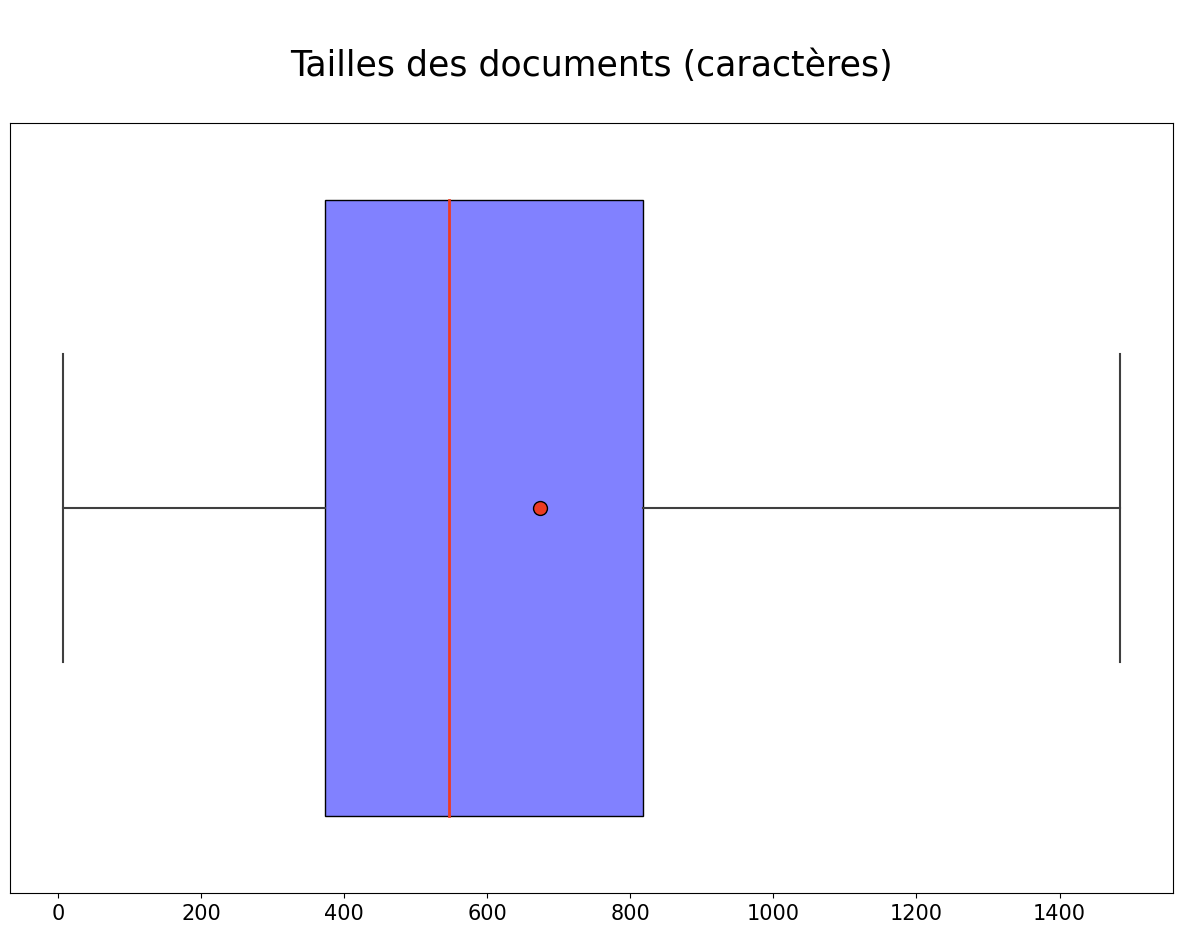

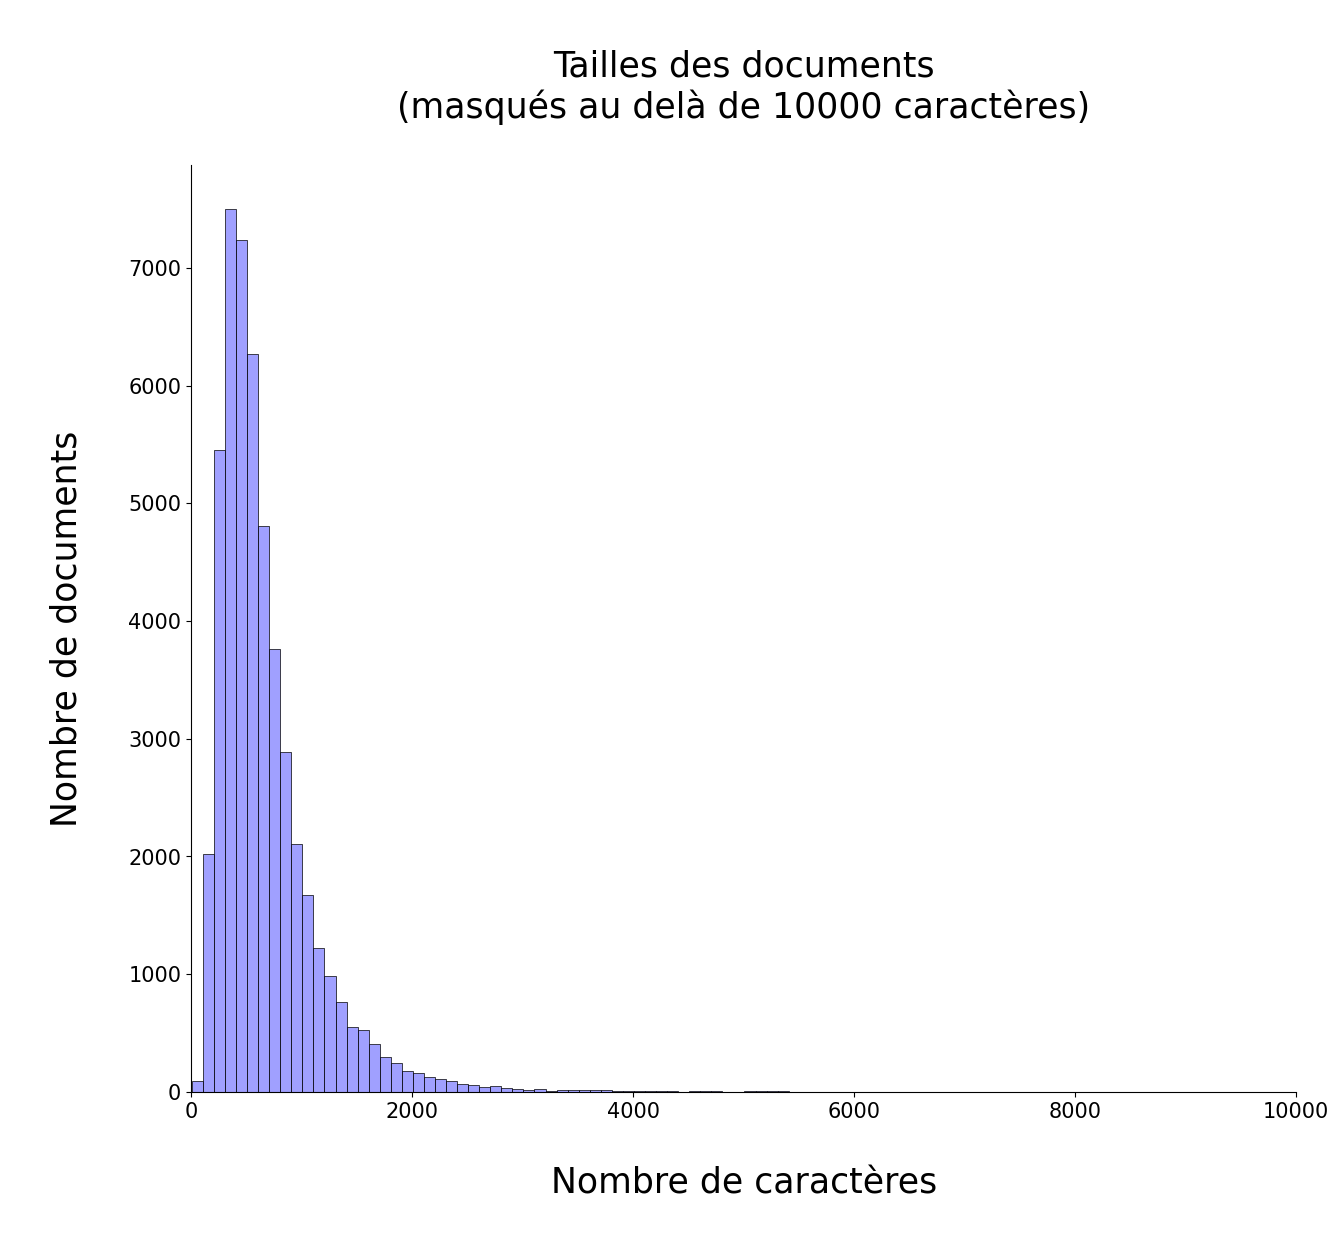

In [20]:
# Taille des documents : 

tmp = data.corpus.str.len()

# Boîte à moustaches :

plt.figure(figsize=(15, 10))
sns.boxplot(tmp,
            orient='h',
            showfliers=False,
            showmeans=True,
            **param_box_plot
    )
plt.yticks([])
plt.xticks(fontsize=15)
plt.title("\nTailles des documents (caractères)\n", fontsize=25)
plt.show()

# Displot : 

x_max = 10000
sns.displot(tmp,
            binwidth=100,
            linewidth=0.5,
            **param_displot
    ).set(xlim=(0, x_max))
plt.yticks(fontsize=15)
plt.ylabel("\nNombre de documents\n", fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel("\nNombre de caractères\n", fontsize=25)
plt.title(f"\nTailles des documents\n(masqués au delà de {x_max} caractères)\n", fontsize=25)
plt.show()

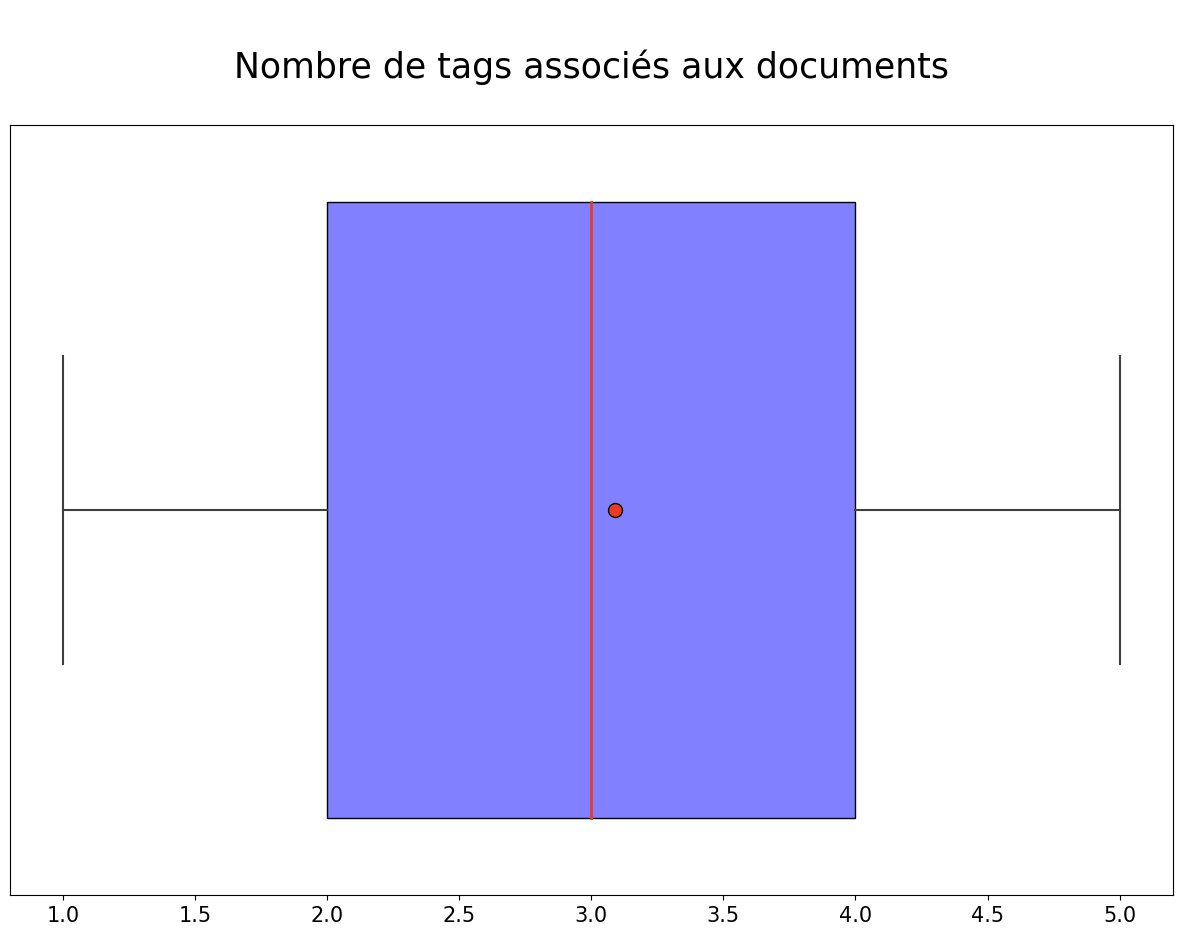

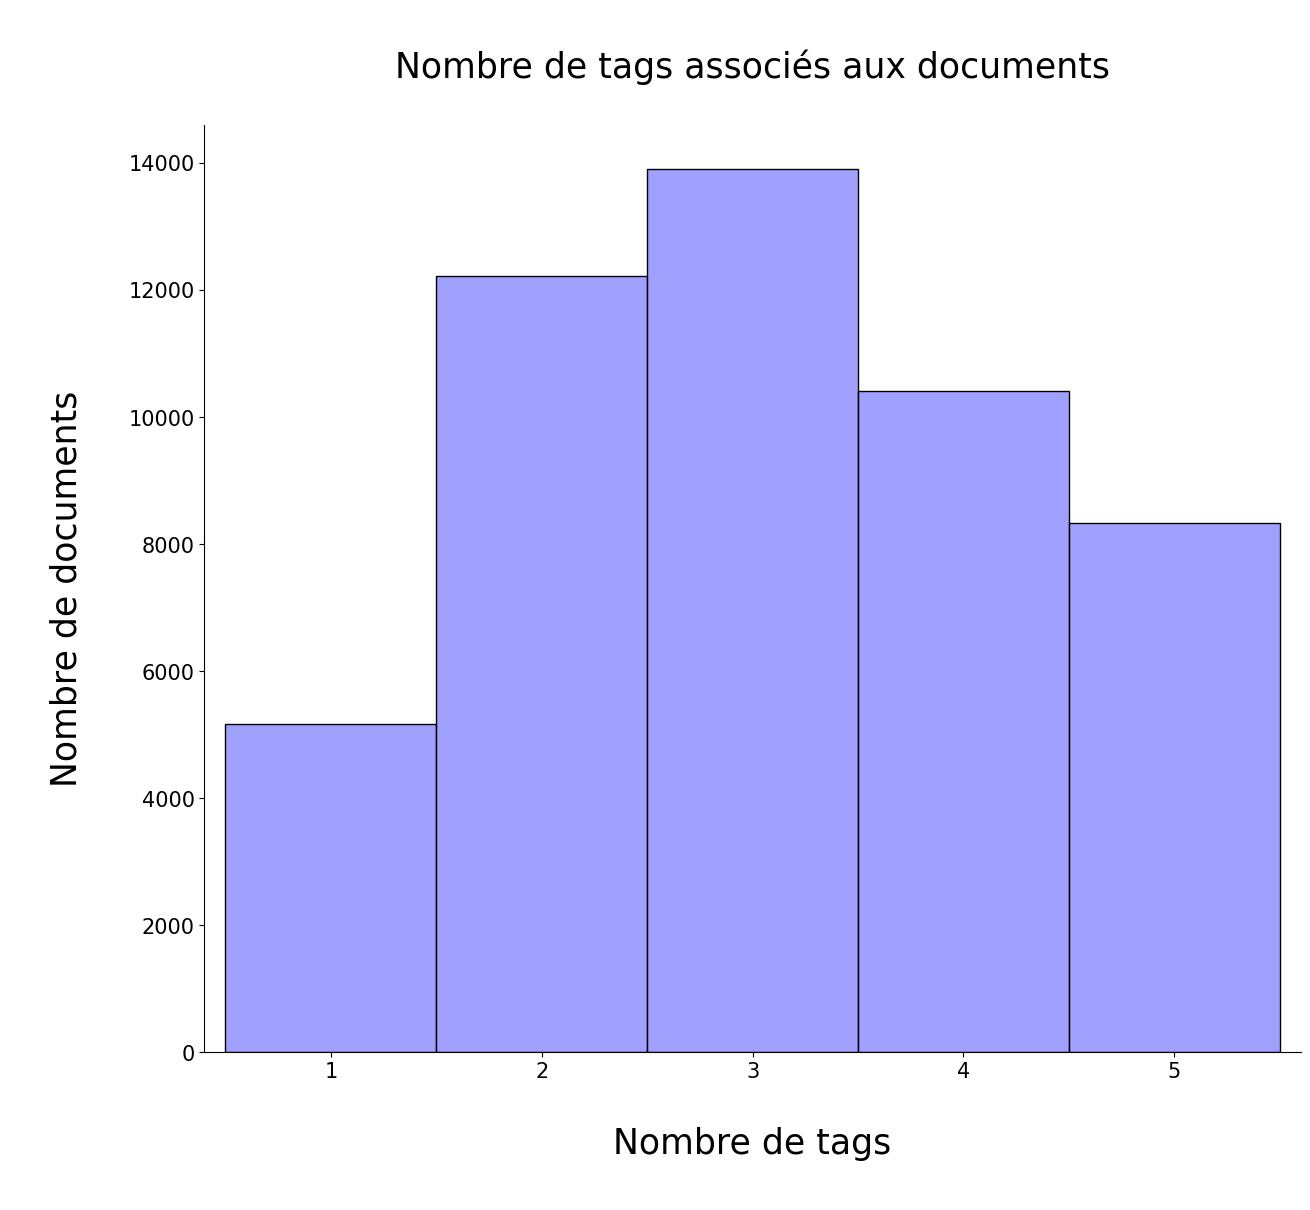

In [21]:
# Nombre de tags : 
tmp = data.tags.str.len()

# Boîte à moustaches :

plt.figure(figsize=(15, 10))
sns.boxplot(tmp,
            orient='h',
            showfliers=False,
            showmeans=True,
            **param_box_plot
    )
plt.yticks([])
plt.xticks(fontsize=15)
plt.title("\nNombre de tags associés aux documents\n", fontsize=25)
plt.show()

# Displot : 

sns.displot(tmp,
            binwidth=1,
            binrange=(0.5, 5.5),
            linewidth=1,
            **param_displot
    ).set(xlim=(0.4, 5.6))
plt.yticks(fontsize=15)
plt.ylabel("\nNombre de documents\n", fontsize=25)
plt.xticks(np.arange(min(tmp), max(tmp) + 1, step=1), fontsize=15)
plt.xlabel("\nNombre de tags\n", fontsize=25)
plt.title(f"\nNombre de tags associés aux documents\n", fontsize=25)
plt.show()

In [22]:
# création de 2 nouvelles variables pour l'exploration

data['question_lenth'] = data.corpus.str.len()
data['tags_number'] = data.tags.str.len()

<Axes: >

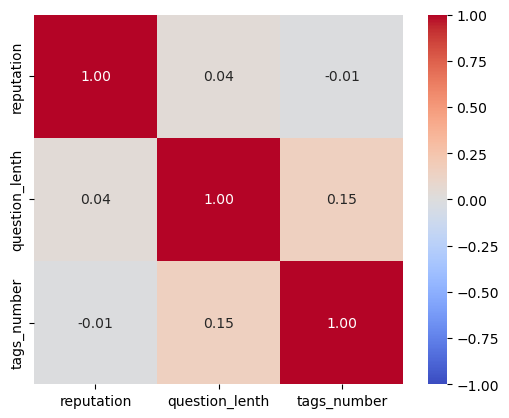

In [23]:
# corrélations entre les variables numériques

corr = data.corr(numeric_only=True)
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", square=True)

In [24]:
# sns.pairplot(data)

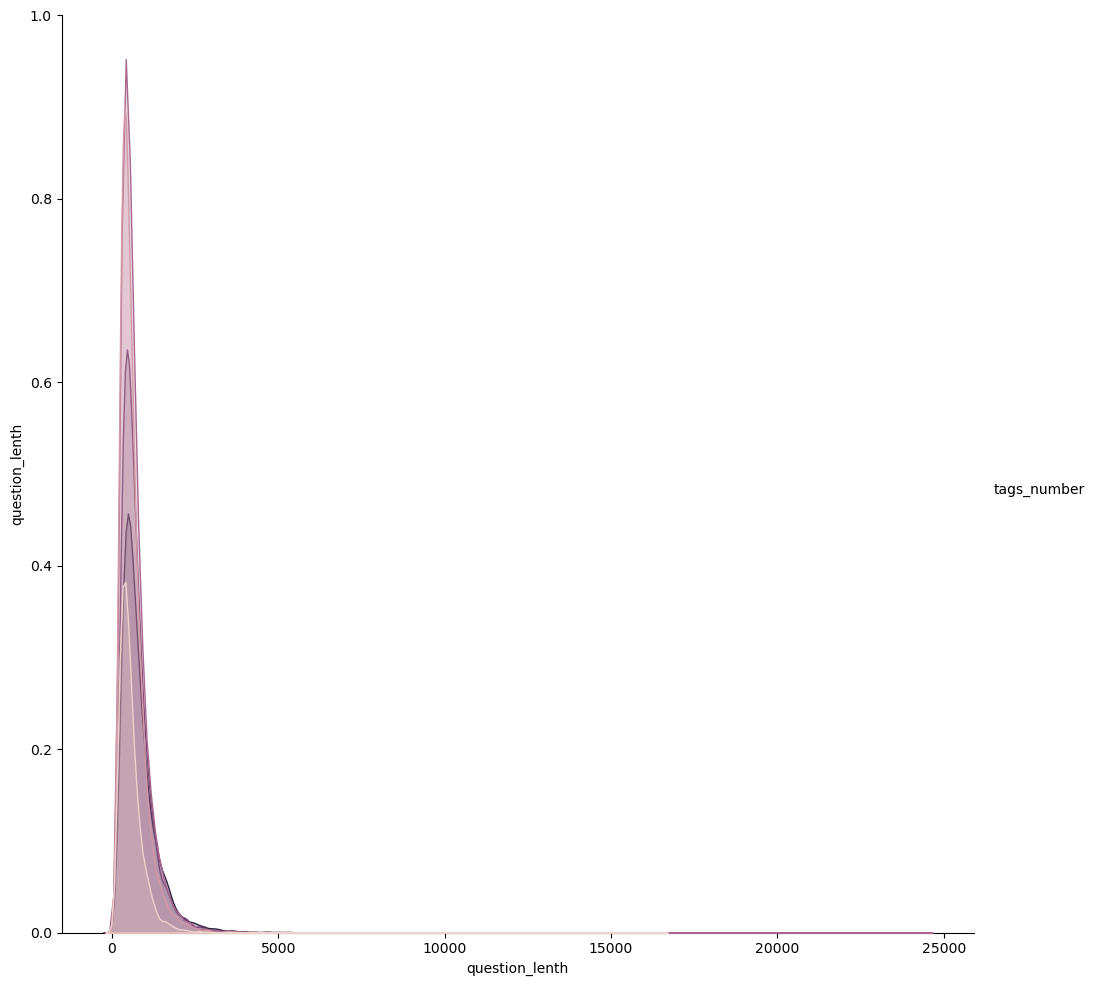

In [25]:
sns.pairplot(data[['question_lenth', 'tags_number']], hue="tags_number", height=10)

In [26]:
for idx, ser in data.sample(5).iterrows():
    txt_1 = f"Tags : {ser['tags']}\n"
    print(txt_1 + ser['corpus']+ "..." + "\n")

Tags : ['tailwind-css']
How to customize max-width of Tailwind Typography plugin I tried this, but it doesn't work:

This is the complete tailwind.config.cjs

...

Tags : ['r', 'data.table', 'outer-join']
Obtain one to one matches from many-to-many linkages, using data.table R I am trying to link two sets of anonymous ID (ID1 and ID3), via a lookup to another ID (ID2). I want to keep only one-to-one matches between ID1 and ID3, but this is tricky as there are many-to-many matches between each ID.

I have tried joining the tables. This is successful in getting rid of cases where ID2 only occurs in one of the tables.

However, it still contains cases where ID1 is linking to multiple ID3 values, and vice versa.
I want to end up with a table like this:

Ideally I would like to do this using  in R.
...

Tags : ['javascript', 'typescript', 'enums']
Index an enum object with case-insensitive key in TypeScript Although not necessary, enum keys are usually declared all in CAPS. However, the enu

# explo faire gaphique avec creationdate

## **Text processing**

### **Commençons par analyser le corpus dans sa globalité**

- Fonctions de base : 

In [27]:
def display_tokens_infos(tokens):
    """Infos de base d'un corpus"""

    print(f"Nombre de tokens : {len(tokens)}\nNombre de tokens uniques : {len(set(tokens))}")
    print(f"10 premiers tokens : {tokens[:10]}")

In [28]:
def basic_cleaning(doc, suppr_doublons=False):
    """Cleaning de base
    
    suppr_doublons : va supprimer les tokens en double dans chaque documents (par défaut : False)
    """

    # Passage en minuscule
    doc = doc.lower().strip()  # .strip() enlève le/les caractère(s) définis à gauche et à droite (espace par défaut)

    # Tokenisation avec NLTK
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)

    # Suppression des stop words
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # Suppression des caractères numériques
    alpha_tokens = [w for w in cleaned_tokens_list if w.isalpha()]

    if suppr_doublons:
        final = list(set(alpha_tokens))
    else:
        final = alpha_tokens
   
    return final

- Définition des stopwords que l'on va utiliser : 

In [29]:
stop_words = set(stopwords.words('english'))

- Traitement préliminaire : suppression des occurences locales.

<div class="alert alert-info">
Avant de créer un corpus global avec tous les documents, il est important de réaliser une étape préliminaire : tokeniser chaque document et supprimer les doublons dans ces derniers. De cette manière, au moment de déterminer la liste des mots rares (apparaissant moins d'un certain nombre de fois dans tout le corpus), nous ne seront plus biaisés par les occurences locales. Ces occurences locales peuvent être importantes, par exemple avec des noms de variables spécifiques à un code présent dans un seul document.
</div>

In [30]:
data['preprocessed_corpus'] = data.corpus.apply(basic_cleaning, suppr_doublons=True)

- Création d'un corpus global en fusionnant toutes les données de la colonne ```data['preprocessed_corpus']``` : 

In [31]:
corpus = [item for sublist in data['preprocessed_corpus'] for item in sublist]

In [32]:
display_tokens_infos(corpus)

Nombre de tokens : 2092424
Nombre de tokens uniques : 59353
10 premiers tokens : ['consume', 'n', 'pulls', 'atn', 'succeeds', 'unconsumed', 'quote', 'tokenizer', 'change', 'stringlisteral']


- Fréquence des tokens : 

In [33]:
# On fait le compte des différents tokens
tmp = pd.Series(corpus).value_counts()

print("Tokens les plus fréquents : ")
display(tmp.head(10))

print("Tokens les moins fréquents : ")
display(tmp.tail(10))

print("Distribution des présences des tokens : ")
display(tmp.describe())


Tokens les plus fréquents : 


using        18772
like         17784
code         17313
get          13649
want         13423
use          13247
would        11732
error        11583
way          11263
following    11071
dtype: int64

Tokens les moins fréquents : 


onbind           1
emaillogin       1
futureor         1
emailpassword    1
emailsettings    1
resumedata       1
frederikhors     1
analyis          1
loopify          1
ioption          1
dtype: int64

Distribution des présences des tokens : 


count    59353.000000
mean        35.253888
std        308.646718
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      18772.000000
dtype: float64

La distribution est très asymétrique : 50% des tokens sont présents 1 seule fois.

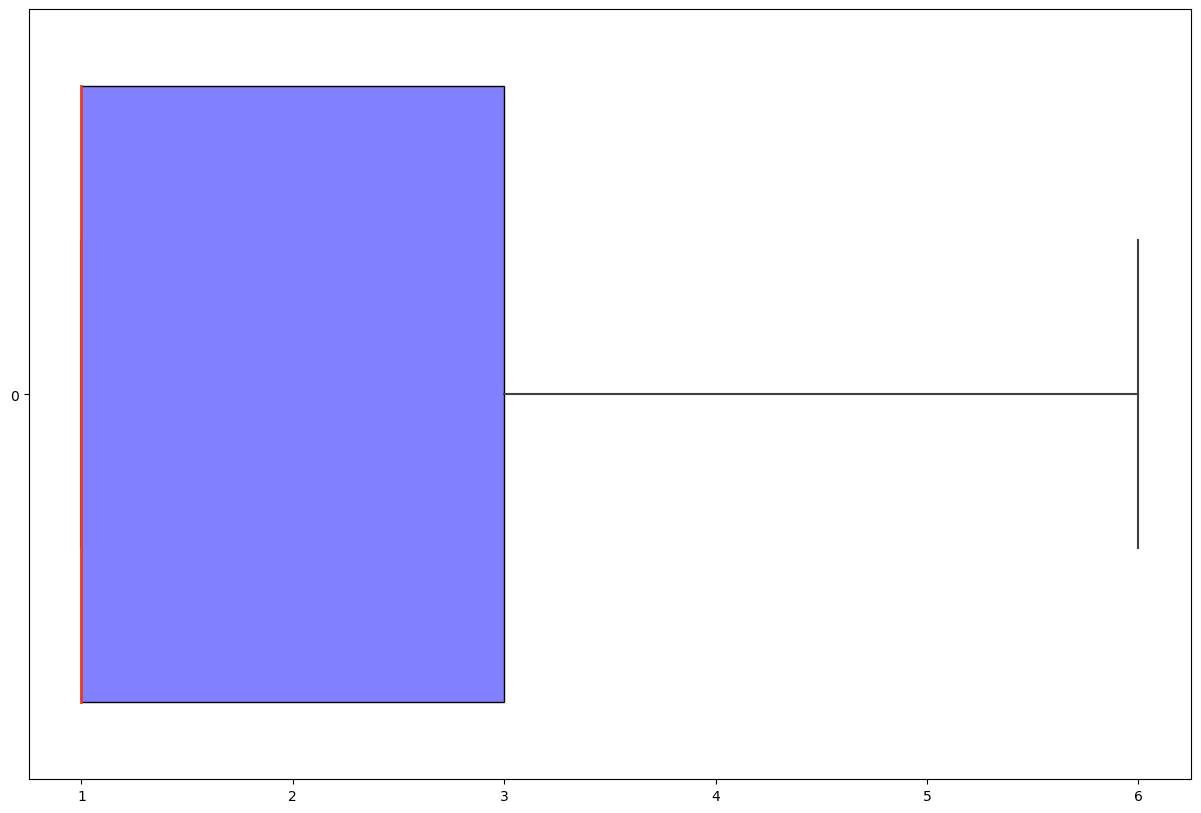

In [34]:
plt.figure(figsize=(15, 10))
sns.boxplot(tmp, orient='h', showfliers=False, showmeans=False, **param_box_plot);


- Mots rares : <br>

Pour un mot unique, il y a de grandes chances soit qu'il soit éliminé lors de méthodes de réduction de dimentionnalité, soit qu'il ne puisse pas être utilisé comme dimention.<br>
Et pour accélérer nos calculs futurs, on a tout intérêt à diminuer la liste de tokens de notre corpus, et donc à supprimer les tokens présents une seule fois.

In [35]:
list_unique_words = tmp[tmp==1]
list_unique_words = list(list_unique_words.index)  # .index = pour ne récupérer que les mots
print(f"Nombre de mots rares : {len(list_unique_words)}")
print(f"Exemples de mots rares : {list_unique_words[:10]}")

Nombre de mots rares : 35530
Exemples de mots rares : ['cachekey', 'turner', 'rectnaglef', 'includif', 'assetstore', 'esprima', 'rectanglef', 'yapf', 'stringtrimming', 'reconstatus']


- Mots présents 5 fois ou moins : 

On peut faire de même avec les mots présents 5 fois ou moins.

In [36]:
list_min_5_words = tmp[tmp<=5]
list_min_5_words = list(list_min_5_words.index)  # .index = pour ne récupérer que les mots
print(f"Nombre de mots présents 5 fois ou moins : {len(list_min_5_words)}")
print(f"Exemples de mots : {list_min_5_words[:10]}")

Nombre de mots présents 5 fois ou moins : 47646
Exemples de mots : ['arcs', 'unsuitable', 'timeit', 'nonstandard', 'shine', 'chroma', 'pinvoke', 'undetected', 'marshalled', 'panes']


Il y en a deux fois plus que de mots uniques.

- Intérêt de traiter les mots présents 10 fois ou moins ?

In [37]:
print(f"Nombre de mots présents 10 fois ou moins : {len(tmp[tmp<=10])}")

Nombre de mots présents 10 fois ou moins : 50810


La différence avec les mots présents 5 fois ou moins n'est pas très grande.

### **Lemmatisation : comparaison de NLTK et SpaCy**

- Exemple de phrase à lemmatiser : 

In [38]:
phrase = "These are sentences going to be translated"
tokenizer = RegexpTokenizer(r"\w+")
phrase_tokens = tokenizer.tokenize(phrase)

- Lemmatisation avec NLTK : 

In [39]:
# Instanciation
wordNetLemmatizer = WordNetLemmatizer()

debut = time.time()  # Heure de début du traitement
lemmaWords1 = [wordNetLemmatizer.lemmatize(word) for word in phrase_tokens]
print(f"Durée du traitement : {(time.time() - debut):.2f} s")

print(f'Tokens après lemmatisation avec WordNet Lemmatizer (NLTK) : \n{phrase} => {lemmaWords1}')

Durée du traitement : 1.53 s
Tokens après lemmatisation avec WordNet Lemmatizer (NLTK) : 
These are sentences going to be translated => ['These', 'are', 'sentence', 'going', 'to', 'be', 'translated']


- Lemmatisation avec SpaCy : 

In [40]:
# Instanciation
spacy_nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])  # 'parser' et 'ner' pas utiles pour le moment

debut = time.time()  # Heure de début du traitement
doc = spacy_nlp(phrase)
print(f"Durée du traitement : {(time.time() - debut):.2f} s")

lemmaWords2 = [word.lemma_ for word in doc]
print(f'Tokens après lemmatisation avec SpaCy : \n{phrase} => {lemmaWords2}')

Durée du traitement : 0.01 s
Tokens après lemmatisation avec SpaCy : 
These are sentences going to be translated => ['these', 'be', 'sentence', 'go', 'to', 'be', 'translate']


- Comparaison des deux résultats : 

In [41]:
print(phrase, "(Texte à lemmatiser)")
print(lemmaWords1, "(NLTK)")
print(lemmaWords2, "(SpaCy)")

These are sentences going to be translated (Texte à lemmatiser)
['These', 'are', 'sentence', 'going', 'to', 'be', 'translated'] (NLTK)
['these', 'be', 'sentence', 'go', 'to', 'be', 'translate'] (SpaCy)


NLTK a juste mis *sentences* au singulier, alors que SpaCy a en plus donné la racine des mots *are*, *going* et *translated*.<br>
Le lemmatiseur de SpaCy semble plus efficace, c'est celui-ci que nous utiliserons.

### **Traitement des documents du corpus**

Voici les traitements que nous allons appliquer aux documents de *```data['corpus']```* : <br>

- Passer tous le texte en minuscule, afin de pouvoir regrouper les mots écrits avec des casses différentes.
- Exclure les mots rares, ceux qui sont présents une seule fois dans tout le corpus.
- Retrait des *Stop Words*, mots commun ayant peu d'intérêt dans le sens global des documents.
- Suppression des mots courts. Les mots très courts ne sont généralement pas ceux qui apportent le plus de sens.
- Suppression des données numériques. Elles ne nous intéressent pas ici.
- Lemmatisation. Afin de réduire la taille du vocabulaire, nous allons regrouper les déclinaisons d'un même mot en sa racine.
- POS (part-of-speech). Nous n'allons garder que les catégories de mots les plus pertinentes.




- Création de la fonction de traitement des documents : 

In [42]:
def process_documents(doc,
                   tokenizer=None,
                   pos=None,
                   lemmentizer=None,
                   rejoin=False,
                   stop_words=None,
                   list_rare_words=None,
                   min_len_word=3,
                   alpha_only=True,
                   extra_words=None,
                   return_set=False
                   ):
    
    """
    Cette fonction permet de tokéniser un texte et d'en réduire la dimension.
    Elle est conçue pour fonctionner avec SpaCy

    ------------------------------------

    Arguments positionnels : 

    doc : le document (texte au format str) à traiter.

    ------------------------------------

    Arguments optionnels : 

    tokenizer (obj) : l'instance du tokenizer à utiliser (par défaut : None).
    lemmentizer (obj) : l'instance du lemmentizer à utiliser (par défaut : None).
    pos (liste) : liste contenant les catégories grammaticales de mot à conserver à l'étape de lemmatisation (par défaut : None).
    rejoin (bool) : si True, retourne une unique chaine de caractère contenant les tokens séparés par un espace (par défaut : False).
    stop_words (set) : liste des stop words à utiliser, privilégier un format en set pour des traitements plus rapides (par défaut : None).
    list_rare_words (set) : liste de mots rares à retirer, privilégier un format en set pour des traitements plus rapides (par défaut : None).
    min_len_word (int) : longueur des mots courts à supprimer, si None aucun mot supprimé (par défaut : 3).
    alpha_only (bool) : utilisation de la méthode .isalpha() pour ne garder que les lettres (par défaur : True).
    extra_words (set) : mots spécifiques supplémentaire à supprimer, privilégier un format en set pour des traitements plus rapides (par défaut : None).
    return_set (bool) : retourner les résultats sous forme de set, pour supprimer les doublons dans les documents (Par défaut : False).

    ------------------------------------

    Renvoie :

    Un string (si join est True) ou un set de tokens.

    """

    # Passage du texte en minuscules
    doc = doc.lower()

    # Tokenisation du texte
    if tokenizer:
        raw_tokens_list = tokenizer.tokenize(doc)
    else:
        raw_tokens_list = doc

    # S'il est choisi de retourner un set, alors nous pouvons dès maintenant
    # supprimer les doublons, les traitements suivants seront plus rapides
    if return_set:
        raw_tokens_list = set(raw_tokens_list)

    # Suppression des stopwords (si fournis)
    if stop_words:
        cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]
    else:
        cleaned_tokens_list = raw_tokens_list

    # Suppression des mots rares (si fournis)
    if list_rare_words:
        non_rare_tokens = [w for w in cleaned_tokens_list if w not in list_rare_words]
    else:
        non_rare_tokens = cleaned_tokens_list

    # Suppression des mots courts (si l'option est activée)
    if not min_len_word:
        more_than_N = non_rare_tokens
    else:
        more_than_N = [w for w in non_rare_tokens if len(w) >= min_len_word]

    # Suppression des caractères numériques (si l'option est activée)
    if alpha_only:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]  # isalpha() sert à retourner True s'il n'y a que des lettres, pas de chiffre
    else:
        alpha_tokens = more_than_N

    # Lemmatisation
    if lemmentizer:
        ecrase = ' '.join(alpha_tokens)  # Il faut "écraser" la liste pour qu'elle puisse passer dans le lemmatizerde Spacy
        doc = lemmentizer(ecrase)
        if pos:
            lemmatized = [word.lemma_ for word in doc if word.pos_ in pos]
        else:
            lemmatized = [word.lemma_ for word in doc]
    else:
        lemmatized = alpha_tokens

    # S'il est choisi de retourner un set, alors nous pouvons dès maintenant
    # supprimer les doublons, les traitements suivants seront plus rapides
    if return_set:
        lemmatized = set(lemmatized)

    # Suppression des extra_words (si fournis)
    if extra_words:
        final = [w for w in lemmatized if w not in extra_words]
    else:
        final = lemmatized

    # Forme des données retournées
    if rejoin:
        final = " ".join(final) # retourne une unique chaine de caractère contenant les tokens séparés par un espace
    
    if return_set:
        return set(final)
    else:
        return final

Préparation des différent éléments nécéssaire aux traitement : <br>
- Instanciation du Tokenizer, nous allons utiliser *RegexpTokenizer* de NLTK.
- Instanciation du Lemmentiseur, nous allons utiliser celui de SpaCy.
- Définition des mots rares, nous allons utiliser ceux apparaissant 5 fois ou moins dans tout le corpus.
- Définition des catégories de mots à conserver, nous allons garder les noms.

In [43]:
# Instanciation du tokenizer
tokenizer = RegexpTokenizer(r"\w+")

# Instanciation du lemmentizer, on désactive les composants dont on a pas besoin
spacy_nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])

# Convertion de la liste de mots rares en set, ce qui va considérablement réduire les temps de calculs
mots_rares = set(list_min_5_words)

# Catégories de mots à garder à l'étape de lemmatisation
pos_a_garder = set([
             #  "ADJ",  # "adjective"
             #  "ADP",  # "adposition"
             #  "ADV",  # "adverb"
             #  "AUX",  # "auxiliary"
             #  "CONJ",  # "conjunction"
             #  "CCONJ",  # "coordinating conjunction"
             #  "DET",  # "determiner"
             #  "INTJ",  # "interjection"
                "NOUN",  # "noun"
             #  "NUM",  # "numeral"
             #  "PART",  # "particle"
             #  "PRON",  # "pronoun"
             #  "PROPN",  # "proper noun"
             #  "PUNCT",  # "punctuation"
             #  "SCONJ",  # "subordinating conjunction"
             #  "SYM",  # "symbol"
             #  "VERB",  # "verb"
             #  "X",  # "other"
             #  "EOL",  # "end of line"
             #  "SPACE",  # "space"
])

- Traitement du corpus : 

In [44]:
debut = time.time()  # Heure de début du traitement
data['processed_corpus'] = data.corpus.apply(process_documents,
                                   doc,
                                   tokenizer=tokenizer,
                                   pos=pos_a_garder,
                                   lemmentizer=spacy_nlp,
                                   rejoin=False,
                                   stop_words=stop_words,
                                   list_rare_words=mots_rares,
                                   min_len_word=3,
                                   alpha_only=True,
                                   extra_words=None,
                                   return_set=False
                             )
print(f"Durée du traitement : {(time.time() - debut):.2f} s")

data

Durée du traitement : 197.17 s


,creationdate,tags,reputation,corpus,question_lenth,tags_number,preprocessed_corpus,processed_corpus
0,2022-05-08 20:40:40,[antlr4],129,Lexer rule to handle escape of quote with quot...,1529,1,"[consume, n, pulls, atn, succeeds, unconsumed,...","[rule, handle, backslash, expand, answer, esca..."
1,2022-05-08 21:22:05,"[reactjs, firebase, jestjs]",121,"Firebase - Testing with Jest throws error ""INT...",476,3,"[jest, use, fine, internal, write, works, foll...","[firebase, testing, jest, error, assertion, cl..."
2,2022-05-08 21:49:08,"[async-await, concurrency, hacklang]",307,Concurrent block in hacklang Since hack is a s...,194,3,"[hacklang, block, using, threaded, understandi...","[block, hack, language, benefit, block, job, w..."
3,2022-05-08 21:49:57,[typescript],1436,Can you set a type for a function in typescrip...,747,1,"[correct, like, say, case, give, required, err...","[type, function, typescript, function, type, i..."
4,2022-05-08 21:51:00,"[expo, google-play-console, google-play-develo...",4346,"Expo EAS Submit, where to store service accoun...",553,3,"[store, successfully, key, g, prompted, someho...","[store, service, account, looking, eas, expo, ..."
...,...,...,...,...,...,...,...,...
49995,2022-03-21 09:01:04,"[ionic-framework, ionic-react]",590,Ionic-React App Automatically Changing to Dark...,481,2,"[started, clear, inconsistency, fine, first, i...","[app, mode, react, app, behaviour, building, a..."
49996,2022-03-21 09:02:39,[stripe-payments],125,is it possible to operate two service in the o...,307,1,"[corp, legal, one, multiple, service, general,...","[service, stripe, account, service, service, d..."
49997,2022-03-21 09:02:54,[terraform],4200,Which security problem does terraform Checksum...,553,1,"[expert, use, dependency, first, documentation...","[security, problem, terraform, dependency, loc..."
49998,2022-03-21 13:54:21,"[azure, azurite]",135,Visual studio 2022 with azurite integrated (v3...,1037,2,"[api, headervalue, correct, azurite, higher, t...","[studio, creation, blob, container, error, mes..."


### **Post traitement**

Lors des traitements, les mots rares du corpus original ont été supprimés.<br>
Cependant, les traitements ont fait apparaitre de nouveaux mots rares, qu'il va falloir supprimer également.<br>

In [45]:
# On regroupe tous les éléments des liste de data['processed_corpus'] dans une liste unique
processed_corpus = [item for sublist in data['processed_corpus'] for item in sublist]

# On fait le compte des différents tokens dans notre corpus traité
tmp = pd.Series(processed_corpus).value_counts()

post_list_min_5_words = tmp[tmp<=5]
post_list_min_5_words = list(post_list_min_5_words.index)  # .index = pour ne récupérer que les mots
print(f"Nombre de mots présents 5 fois ou moins : {len(post_list_min_5_words)}")
print(f"Exemples de mots : {post_list_min_5_words[:10]}")

Nombre de mots présents 5 fois ou moins : 1582
Exemples de mots : ['sam', 'employ', 'branching', 'unsubscribe', 'telerik', 'jsonproperty', 'pathlib', 'inplace', 'styler', 'rgba']


- Définition de la fonction de suppression des mots rares post traitement : 

In [46]:
def post_rare_suppr(doc,
                    post_rare_words=None
                   ):
        # Suppression des mots rares (si fournis)
    if post_rare_words:
        non_rare_tokens = [w for w in doc if w not in post_rare_words]
    else:
        non_rare_tokens = doc
    return non_rare_tokens

- Transformation de *post_list_min_5_words* en set pour un traitement plus rapide.

In [47]:
post_list_min_5_words = set(post_list_min_5_words)

- Suppression des nouveaux mots apparaissant 5 fois ou moins : 

In [48]:
data['processed_corpus'] = data.processed_corpus.apply(post_rare_suppr,post_rare_words=post_list_min_5_words)

### **Comparaison du corpus d'origine avec le corpus traitré**

- Corpus d'origine (tokenisé, sans stop words et sans nombre) : 

In [49]:
display_tokens_infos(corpus)

# On fait le compte des différents tokens
tmp = pd.Series(corpus).value_counts()

print()

print("Tokens les plus fréquents : ")
display(tmp.head(10))

print("Tokens les moins fréquents : ")
display(tmp.tail(10))

print("Distribution des présences des tokens : ")
display(tmp.describe())

Nombre de tokens : 2092424
Nombre de tokens uniques : 59353
10 premiers tokens : ['consume', 'n', 'pulls', 'atn', 'succeeds', 'unconsumed', 'quote', 'tokenizer', 'change', 'stringlisteral']

Tokens les plus fréquents : 


using        18772
like         17784
code         17313
get          13649
want         13423
use          13247
would        11732
error        11583
way          11263
following    11071
dtype: int64

Tokens les moins fréquents : 


onbind           1
emaillogin       1
futureor         1
emailpassword    1
emailsettings    1
resumedata       1
frederikhors     1
analyis          1
loopify          1
ioption          1
dtype: int64

Distribution des présences des tokens : 


count    59353.000000
mean        35.253888
std        308.646718
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      18772.000000
dtype: float64

- Corpus traité avec ```process_documents()``` et post traité avec ```post_rare_suppr()``` : 

In [50]:
# Pour récupérer les mots qui sont dans des set à chaque ligne
processed_corpus = data['processed_corpus'].explode().tolist()

display_tokens_infos(processed_corpus)

# On fait le compte des différents tokens
tmp = pd.Series(processed_corpus).value_counts()

print("Tokens les plus fréquents : ")
display(tmp.head(10))

print("Tokens les moins fréquents : ")
display(tmp.tail(10))

print("Distribution des présences des tokens : ")
display(tmp.describe())

Nombre de tokens : 1327556
Nombre de tokens uniques : 5248
10 premiers tokens : ['rule', 'handle', 'backslash', 'expand', 'answer', 'escape', 'escape', 'character', 'work', 'equivalent']
Tokens les plus fréquents : 


code        25327
error       23378
file        21534
function    18602
value       18387
way         15180
type        14018
datum       13079
example     11769
work        11691
dtype: int64

Tokens les moins fréquents : 


owl            6
clr            6
entropy        6
sourcemap      6
remembering    6
changing       6
sm             6
itemssource    6
teaching       6
adt            6
dtype: int64

Distribution des présences des tokens : 


count     5247.000000
mean       253.010673
std       1074.627521
min          6.000000
25%         12.000000
50%         28.000000
75%        104.000000
max      25327.000000
dtype: float64

- Pour test : 

In [51]:
mot_a_tester = "duplicating"

if mot_a_tester in processed_corpus:
    print(f"Le mot '{mot_a_tester}' se trouve dans 'processed_corpus'.")
else:
    print(f"Le mot '{mot_a_tester}' ne se trouve pas dans 'processed_corpus'.")

Le mot 'duplicating' se trouve dans 'processed_corpus'.


In [52]:
mot_a_tester = "duplicating"

if mot_a_tester in corpus:
    print(f"Le mot '{mot_a_tester}' se trouve dans 'corpus'.")
else:
    print(f"Le mot '{mot_a_tester}' ne se trouve pas dans 'corpus'.")

Le mot 'duplicating' se trouve dans 'corpus'.
